## IMDB


In [1]:
# importar bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.formula.api as smf

In [2]:
# abrir imdb dataset
df_basics = pd.read_csv('C:/Users/camil/Desktop/Projeto Integrador/dados/title.basics.tsv.gz', compression='gzip', header=0 , quotechar='"', error_bad_lines=False, sep = '\t', na_values=['\\N'])

C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# converter em float
df_basics['year'] = df_basics['startYear'].astype(np.float)

# filtrar starYear >= 2000
basics = df_basics[(df_basics.year >= 2000) & (df_basics.year <= 2020)]

In [4]:
# renomear colunas para juntar os datasets
basics.rename(columns = {'primaryTitle': 'movie_name'}, inplace = True)

C:\Users\camil\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [5]:
# abrir df
df_rotten = pd.read_csv('C:/Users/camil/Desktop/Projeto Integrador/dados/rt_movie_info.csv', encoding = 'latin1', engine = 'python', delimiter = ',')

In [6]:
# remover linhas duplicadas
df_rotten.drop_duplicates(subset ="movie_name", 
                     keep = False, inplace = True)

In [7]:
# transformar em float
df = df_rotten.copy()
df['year'] = df['in_theaters_date'].str[-5:].astype(np.float)


# filtrar year >= 2000
df = df[(df.year >= 2000) & (df.year <= 2020)]

## Juntar IMDB e Rotten Tomatoes

Criar uma nova coluna que junte o título do filme com o ano.

In [8]:
df['movieyear'] = df.year.astype(str) + df.movie_name

In [9]:
basics['movieyear'] = basics.year.astype(str) + basics.movie_name

C:\Users\camil\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
# left join por filme e ano
#df_rt = df.merge(basics, on = ['movieyear'], how = 'left')
df_rt = df.join(basics.set_index('movieyear'), on = 'movieyear', how = 'left', lsuffix='_rotten', rsuffix='_imdb')

In [11]:
df_rt.drop_duplicates(subset ="movieyear", 
                     keep = False, inplace = True)

In [12]:
# converter para formato de data

## converter para data
df_rt['in_theaters_date'] = df_rt.in_theaters_date.astype('datetime64')

## pegar apenas o ano
df_rt['date_year'] = df_rt.in_theaters_date.dt.year

## pegar apenas o mes
df_rt['date_month'] = df_rt.in_theaters_date.dt.month

## filtrar date_year >= 2010
df_rt2 = df_rt[df_rt.date_year >= 2000]

In [13]:
print("Agora o dataset tem:", df_rt2.shape[0], "filmes")

Agora o dataset tem: 2353 filmes


#### tomatometer

In [14]:
print(round(df_rt2.tomatometer_status.count()/len(df_rt2) * 100, 2),'% do dataset tem tomatometer status')

84.11 % do dataset tem tomatometer status


In [15]:
# criar uma variavel dummy com status do tomatometer 
## rotten = 0
## fresh|certified_fresh = 1
df_rt2['status_dummy'] = df_rt2.loc[:, 'tomatometer_status'].replace({'rotten': 0,
                                                      'fresh': 1,
                                                      'certified_fresh':1})

In [16]:
df_rt2['status_dummy'].value_counts()

1.0    1049
0.0     930
Name: status_dummy, dtype: int64

#### movie_info

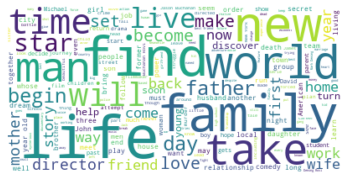

In [17]:
# plotar as palavras mais frquentes nos filmes 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# combinar linhas multiplas em um objeto
text = df_rt2['movie_info'].str.cat(sep='/ ')

# Ciar uma lista de STOPWORDS:
stopwords = set(STOPWORDS)
stopwords.update(["one", "two", "tree", "four", "five", "six", "seven", "eight", "nine", "film"])


# Criar e gerar uma nuvem de palavra:
wc= WordCloud(stopwords = stopwords, background_color="white").generate(text)

# Mostrar a imagem gerada:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#wc.to_file("rotten.png")
#codigo adaptado de: https://www.datacamp.com/community/tutorials/wordcloud-python

##### Rotten and Fresh Wordclouds

In [18]:
text_rotten = df_rt2.loc[('status_dummy' == 0):,'movie_info'].str.cat(sep='/ ')
text_fresh = df_rt2.loc[('status_dummy' == 1):,'movie_info'].str.cat(sep='/ ')

stopwords = set(STOPWORDS)
stopwords.update(["one", "two", "tree", "four", "five", "six", "seven", "eight", "nine", "film"])


wc_rotten= WordCloud(stopwords = stopwords, background_color="white").generate(text_rotten)
wc_fresh = WordCloud(stopwords = stopwords, background_color="white").generate(text_fresh)

#adapted code from: https://www.datacamp.com/community/tutorials/wordcloud-python

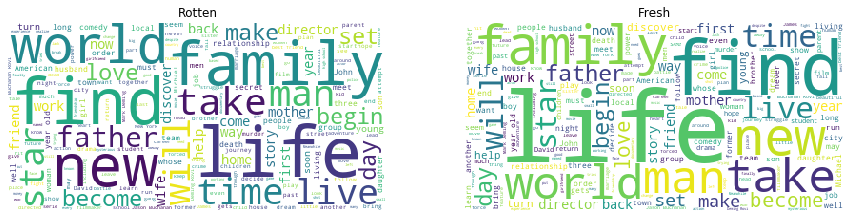

In [19]:
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(wc_rotten)
axarr[0].axis("off")
axarr[0].set_title("Rotten")
axarr[1].imshow(wc_fresh)
axarr[1].axis("off")
axarr[1].set_title("Fresh")
plt.show()

### Rotten Review

In [177]:
review_rt = pd.read_csv('C:/Users/camil/Desktop/Projeto Integrador/dados/rt_movie_review.csv')

In [164]:
df_rt2.rename(columns = {'movie_link': 'movie_id'}, inplace = True)

In [165]:
## right join the two rotten tomatoes df
rotten = review_rt.merge(df_rt2, on = 'movie_id', how = 'right')

In [23]:
rotten.shape

(162135, 53)

In [24]:
rotten.to_csv('rotten.csv',index=False)

Text(0, 0.5, '')

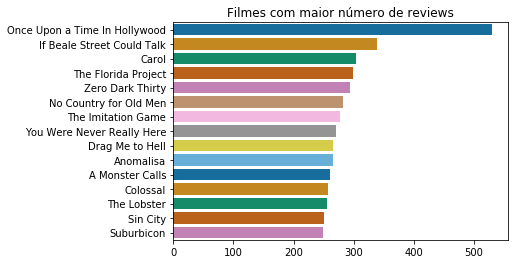

In [25]:
sns.countplot(y = rotten.movie_name_imdb, order = rotten.movie_name_imdb.value_counts().iloc[:15].index, palette = 'colorblind')
plt.title('Filmes com maior número de reviews')
plt.xlabel('')
plt.ylabel('')

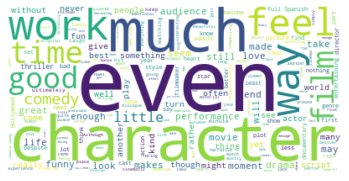

In [26]:
# plotar as palavras mais frequentes no conteudo da review 
text_review = rotten['review_content'].str.cat(sep='/ ')


stopwords = set(STOPWORDS)
stopwords.update(['movie', 'review', 'film', 'one', 'two', 'three', 'story', 'make'])


wc_review= WordCloud(stopwords = stopwords, background_color="white").generate(text_review)

plt.imshow(wc_review, interpolation='bilinear')
plt.axis("off")
plt.show()

In [27]:
review_rotten = rotten.loc[('status_dummy' == 0):,'review_content'].str.cat(sep='/ ')
review_fresh = rotten.loc[('status_dummy' == 1):,'review_content'].str.cat(sep='/ ')

stopwords = set(STOPWORDS)
stopwords.update(['movie', 'review', 'film', 'one', 'two', 'three', 'story', 'make'])


wc_rr= WordCloud(stopwords = stopwords, background_color="white").generate(review_rotten)
wc_rf = WordCloud(stopwords = stopwords, background_color="white").generate(review_fresh)

#adapted code from: https://www.datacamp.com/community/tutorials/wordcloud-python

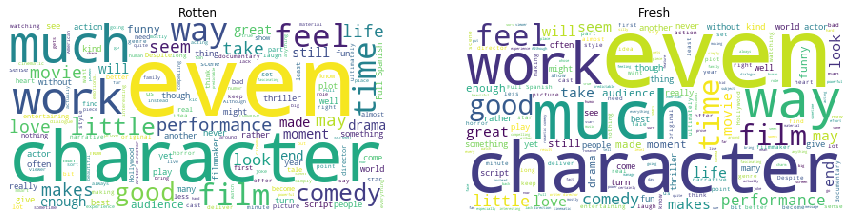

In [28]:
f, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(wc_rr)
ax[0].axis("off")
ax[0].set_title("Rotten")
ax[1].imshow(wc_rf)
ax[1].axis("off")
ax[1].set_title("Fresh")
plt.show()

## NLP

### Tratar os dados

In [29]:
# copiar o df rotten para tratarmos os dados
nlp_df = rotten.copy()

# transformar tudo em minisculo
#nlp_df['review_content'] = nlp_df.review_content.str.lower()

# remover pontuacao
#nlp_df['review_content'] = nlp_df['review_content'].str.replace('[^\w\s]', '')

# remover numeros
#nlp_df['review_content'] = nlp_df['review_content'].str.replace('\d+', '')


In [30]:
'''# remover stop words
import nltk
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

stop = stopwords.words('english')
nlp_df['review_content'] = nlp_df['review_content'].apply(lambda x: " ".join(x.lower() for x in str(x).split() \
                                    if x not in stop))'''

In [39]:
'''# aplicar a funcao tokenize ao conteudo
from nltk.tokenize import word_tokenize
nlp_df['tokenized_content'] = nlp_df['review_content'].apply(word_tokenize)'''

"# aplicar a funcao tokenize ao conteudo\nfrom nltk.tokenize import word_tokenize\nnlp_df['tokenized_content'] = nlp_df['review_content'].apply(word_tokenize)"

In [38]:
'''# aplicar a funcao Lemmatizer

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nlp_df['review_content'] = nlp_df['review_content'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))'''

'# aplicar a funcao Lemmatizer\n\nfrom nltk.stem import WordNetLemmatizer\nlemmatizer = WordNetLemmatizer()\nnlp_df[\'review_content\'] = nlp_df[\'review_content\'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))'

In [37]:
'''nlp_df['review_content'].isna()'''

"nlp_df['review_content'].isna()"

In [34]:
'''from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)
cv.fit(nlp_df['review_content'])
X = cv.transform(nlp_df['review_content'])
X_test = cv.transform(nlp_df['review_content'])'''

https://hub.packtpub.com/how-to-perform-sentiment-analysis-using-python-tutorial/

### Análise de Sentimento

In [166]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews

In [167]:
def extract_features(word_list):
    return dict([(word, True) for word in word_list])

In [168]:
if __name__=='__main__':
   # Load positive and negative reviews  
   positive_fileids = movie_reviews.fileids('pos')
   negative_fileids = movie_reviews.fileids('neg')

In [169]:
features_positive = [(extract_features(movie_reviews.words(fileids=[f])), 'Positive') 
                     for f in positive_fileids]
features_negative = [(extract_features(movie_reviews.words(fileids=[f])), 'Negative') 
                     for f in negative_fileids]

In [170]:
# Split the data into train and test (80/20)
threshold_factor = 0.8
threshold_positive = int(threshold_factor * len(features_positive))
threshold_negative = int(threshold_factor * len(features_negative))

In [171]:
features_train = features_positive[:threshold_positive] + features_negative[:threshold_negative]
#features_test = features_positive[threshold_positive:] + features_negative[threshold_negative:]   

In [172]:
features_test = features_positive[threshold_positive:] + features_negative[threshold_negative:]

In [173]:
# Train a Naive Bayes classifier
classifier = NaiveBayesClassifier.train(features_train)
nltk.classify.util.accuracy(classifier, features_test)

0.735

In [180]:
df_review = review_rt.dropna(subset = ['review_content'])
input_reviews = review_rt.review_content

In [181]:
df_review.shape

(431962, 8)

In [182]:
print("\nPredictions:")
for review in input_reviews:
        print("\nReview:", review)
        probdist = classifier.prob_classify(extract_features(review.split()))
        pred_sentiment = probdist.max()
        print("Predicted sentiment:", pred_sentiment)
        print("Probability:", round(probdist.prob(pred_sentiment), 2))


Predictions:

Review: Has more belly laughs than 10 studio-produced, star-vehicle comedies.
Predicted sentiment: Negative
Probability: 0.73

Review: Calling this story about a quirky high-school student from a dysfunctional family who lives in a goofy small town a one-joke movie is exaggerating by a factor of 10.
Predicted sentiment: Positive
Probability: 0.94

Review: There are lots of laughs for those who enjoy the sight of bottom dwellers doing stupid things that make them look even more idiotic.
Predicted sentiment: Negative
Probability: 0.71

Review: For those who think there'e nothing funnier than yokels acting like idiots for 90 minutes straight.
Predicted sentiment: Negative
Probability: 0.98

Review: We laugh at all the nerdy behavior in the movie, and there's a reason that's OK: Because, deep down, we know we are all nerds.
Predicted sentiment: Negative
Probability: 0.75

Review: He makes Geekus Hollywoodium -- always played by someone such as Ben Stiller, whom we know to be

AttributeError: 'float' object has no attribute 'split'

In [183]:
print("Predicted sentiment:"), pred_sentiment 
print("Probability:"), round(probdist.prob(pred_sentiment), 2)

Predicted sentiment:
Probability:


(None, 0.83)

In [184]:
pred_sentiment = [] 

for review in df_review.review_content:
        probdist = classifier.prob_classify(extract_features(review.split()))
        pred_sentiment.append(probdist.max())
       
df_review['pred_sentiment'] = pred_sentiment  

C:\Users\camil\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [185]:
df_review.pred_sentiment.value_counts()

Positive    311304
Negative    120658
Name: pred_sentiment, dtype: int64

In [186]:
df_review.head()

,movie_link,movie_id,review_date,critic_publication,critic_icon,critic_top,critic_score,review_content,pred_sentiment
0,https://www.rottentomatoes.com/m/napoleon_dyna...,/m/10007,01/07/2004,Arizona Republic,fresh,Top Critic,4/5,"Has more belly laughs than 10 studio-produced,...",Negative
1,https://www.rottentomatoes.com/m/napoleon_dyna...,/m/10007,01/07/2004,Minneapolis Star Tribune,rotten,Top Critic,0.5/4,Calling this story about a quirky high-school ...,Positive
2,https://www.rottentomatoes.com/m/napoleon_dyna...,/m/10007,02/06/2004,Variety,rotten,Top Critic,NaN,There are lots of laughs for those who enjoy t...,Negative
3,https://www.rottentomatoes.com/m/napoleon_dyna...,/m/10007,02/06/2004,Slant Magazine,rotten,NaN,.5/4,For those who think there'e nothing funnier th...,Negative
4,https://www.rottentomatoes.com/m/napoleon_dyna...,/m/10007,02/07/2004,St. Paul Pioneer Press,fresh,NaN,3.5/4,We laugh at all the nerdy behavior in the movi...,Negative


In [187]:
rotten.shape

(162135, 53)

In [188]:
df_review.shape

(431962, 9)

In [190]:
df_group = pd.pivot_table(df_review, 
                      values='movie_link', 
                      index='movie_id', 
                      columns='pred_sentiment',
                      aggfunc='count',
                      margins = 'True',
                      fill_value = 0)

In [193]:
df_group.shape

(4782, 3)

In [191]:
df_group.head()

pred_sentiment,Negative,Positive,All
movie_id,,,
/m/10007,55,115,170
/m/10010,17,24,41
/m/10014,49,207,256
/m/10015,56,120,176
/m/10016,74,98,172


In [196]:
#calcular sentimento %
df_group['negative_perc'] = df_group['Negative'] / df_group['All'] * 100
df_group['positive_perc'] = df_group['Positive'] / df_group['All'] * 100

In [197]:
df_group.head()

pred_sentiment,Negative,Positive,All,negative_perc,positive_perc
movie_id,,,,,
/m/10007,55,115,170,32.352941,67.647059
/m/10010,17,24,41,41.463415,58.536585
/m/10014,49,207,256,19.140625,80.859375
/m/10015,56,120,176,31.818182,68.181818
/m/10016,74,98,172,43.023256,56.976744


In [198]:
## right join the two rotten tomatoes df
critica_df = df_group.merge(df_rt2, on = 'movie_id', how = 'right')

In [200]:
critica_df.shape

(2353, 51)

In [203]:
critica_df.to_csv('rotten.csv',index=False)

In [205]:
df_group.to_csv('critica.csv', index = False)